[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


Import libraries:

In [ ]:
import os, glob, cv2
from random import randint
import numpy as np
import pathlib
from collections import Counter
from keras.utils import to_categorical
from sklearn import preprocessing
import collections
import glob
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.utils import class_weight
import random
from keras.preprocessing import image
from keras.models import Model
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import layers, models
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
import sklearn.metrics as metrics
from keras.layers import Conv2D, MaxPool2D, Flatten, BatchNormalization, Activation, MaxPooling2D
from keras.optimizers import Adam

See Kaggle folder content:

In [ ]:
path = '/gdrive/My Drive/Colab Notebooks/Facial-Expression/facial-expression/'
os.listdir(path)

['fer2013',
 'example_submission.csv',
 'fer2013.tar.gz',
 'icml_face_data.csv',
 'test.csv',
 'train.csv']

Load the data:

In [ ]:
import pandas as pd

df = pd.read_csv(path+'icml_face_data.csv')

df.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


Prepare and split data into train, test, and validation:

In [ ]:
training = df[df[' Usage'] == 'Training']
test = df[df[' Usage'] == 'PublicTest']
validation = df[df[' Usage'] == 'PrivateTest']

In [ ]:
def getImgLabel(df1):
  '''It returns images and labels for each dataframe'''

  labels = []
  images = []
  
  df1.reset_index(drop=True, inplace=True)

  for j in range(len(df1)):
    image = np.fromstring(df1.loc[j, ' pixels'], dtype=int, sep=' ')
    image = np.reshape(image, (48, 48))
    images.append(image)
  labels.append(df1['emotion'].tolist())

  return np.array(labels[0]), np.array(images)

In [ ]:
train_labels, train_images = getImgLabel(training)
test_labels, test_images = getImgLabel(test)
val_labels, val_images = getImgLabel(validation)

In [ ]:
print('Train images count:', len(train_images))
print('Train labels count:', len(train_labels))
print('')
print('Test images count:', len(test_images))
print('Test labels count:', len(test_labels))
print('')
print('Validation images count:', len(val_images))
print('Validation images count:', len(val_labels))

Train images count: 28709
Train labels count: 28709

Test images count: 3589
Test labels count: 3589

Validation images count: 3589
Validation images count: 3589


In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

count_train = Counter(train_labels)
lists = sorted(count_train.items()) # sorted by key, return a list of tuples
print(lists)

[(0, 3995), (1, 436), (2, 4097), (3, 7215), (4, 4830), (5, 3171), (6, 4965)]


Set class weights:

In [ ]:
def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: float(majority/count) for cls, count in counter.items()}

class_weight = get_class_weights(train_labels)

class_weight

{0: 1.8060075093867334,
 1: 16.548165137614678,
 2: 1.7610446668293873,
 3: 1.0,
 4: 1.4937888198757765,
 5: 2.275307473982971,
 6: 1.4531722054380665}

Prepare data to fit in CNN:

In [ ]:
train_images = (train_images.reshape((train_images.shape[0], 48, 48, 1))).astype('float32')/255
val_images = (val_images.reshape((val_images.shape[0], 48, 48, 1))).astype('float32')/255
test_images = (test_images.reshape((test_images.shape[0], 48, 48, 1))).astype('float32')/255

In [ ]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
val_labels = to_categorical(val_labels)

Build CNN

In [ ]:
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model = models.Sequential()
#model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)))
#model.layers[0].set_weights(weights)
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# model.add(layers.Conv2D(512, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))

# model.add(layers.Conv2D(512, (3, 3), activation='relu'))

model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model = models.Sequential()
#Module1 conv<<conv<<batchnorm<<relu<<maxpooling<<dropout
model.add(Conv2D(2*32,kernel_size=(3,3),padding='same',data_format='channels_last',input_shape=(48, 48, 1)))
model.add(Conv2D(2*32,kernel_size=(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.2))
#Module2 conv<<conv<<batchnorm<<relu<<maxpool<<dropout
model.add(Conv2D(2*2*32,kernel_size=(3,3),padding='same'))
model.add(Conv2D(2*2*32,kernel_size=(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.2))
#Module3 conv<<conv<<batchnorm<<relu<<maxpool<<dropout
model.add(Conv2D(2*2*2*32,kernel_size=(1,1),padding='same'))
model.add(Conv2D(2*2*2*32,kernel_size=(1,1),strides=(2,2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.2))
#Module4 fc<<batchnorm<<fc<<batchnorm<<dropout<<softmax
model.add(Flatten())
model.add(Dense(units=128))
model.add(BatchNormalization())
model.add(Dense(units=128))
model.add(BatchNormalization())
model.add(Dropout(rate=0.2))
model.add(Dense(7,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999),metrics=['accuracy'])

In [ ]:
history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    #class_weight = class_weight,
                    epochs=100,
                    batch_size=64)

Epoch 1/100
449/449 [==============================] - 8s 17ms/step - loss: 1.8240 - accuracy: 0.3027 - val_loss: 1.9298 - val_accuracy: 0.2792
Epoch 2/100
449/449 [==============================] - 7s 16ms/step - loss: 1.4877 - accuracy: 0.4335 - val_loss: 1.3816 - val_accuracy: 0.4795
Epoch 3/100
449/449 [==============================] - 7s 16ms/step - loss: 1.3693 - accuracy: 0.4780 - val_loss: 1.3152 - val_accuracy: 0.4848
Epoch 4/100
449/449 [==============================] - 7s 16ms/step - loss: 1.3115 - accuracy: 0.5025 - val_loss: 1.3601 - val_accuracy: 0.4809
Epoch 5/100
449/449 [==============================] - 7s 16ms/step - loss: 1.2755 - accuracy: 0.5192 - val_loss: 1.2363 - val_accuracy: 0.5274
Epoch 6/100
449/449 [==============================] - 7s 16ms/step - loss: 1.2453 - accuracy: 0.5299 - val_loss: 1.4150 - val_accuracy: 0.4923
Epoch 7/100
449/449 [==============================] - 7s 16ms/step - loss: 1.2245 - accuracy: 0.5375 - val_loss: 1.2753 - val_accuracy:

KeyboardInterrupt: ignored

Plot accuracies:

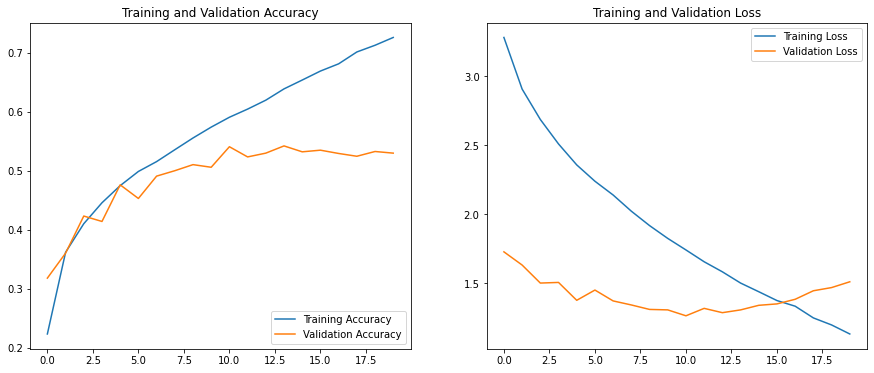

In [ ]:
# visualize the model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Plot confussion matrix:

In [ ]:
# https://stackoverflow.com/questions/51282098/plotting-confusion-matrix-for-an-image-classification-model

from sklearn.metrics import classification_report
import sklearn.metrics as metrics


classes = ['0','1','2','3', '4', '5', '6']

Y_pred = model.predict(test_images)

y_preds = np.argmax(Y_pred, axis=1)

y_preds

#print('Confusion Matrix')
#print(metrics.confusion_matrix(test_labels, y_preds))
#print("")
#print('Classification Report')
#print(classification_report(test_labels, y_preds, target_names=classes))

array([2, 1, 0, ..., 4, 0, 5])